# Lecture 5: Model Training
Welcome to this hands-on tutorial on **training neural networks effectively**. In this notebook, we’ll explore essential concepts and techniques to optimize the training process and improve model performance for a specific application.

Training a neural network involves more than just feeding data and adjusting weights—it requires thoughtful strategies to ensure stability, efficiency, and generalization. This module focuses on key elements such as **data normalization**, **weight normalization**, selecting the best **optimizer**, and preventing overfitting through **regularization**.

By the end of this notebook, you’ll understand how to:

1) Apply data and weight normalization to stabilize and speed up training.
2) Choose an appropriate optimizer to efficiently minimize the loss function.
3) Implement regularization techniques, such as dropout and weight decay, to reduce overfitting and improve model generalization.

Through practical examples and hands-on coding exercises, you’ll gain the skills to fine-tune the training process and achieve better results with your neural networks. Let’s get started and master the art of model training!

## Prerequisites
Lets get started for this week by importing the requirements.

In [1]:
import os

import pdb
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

%matplotlib inline


Let us start with a simple 4 layer network (3 convolutional layers and one fully connected). Even tough the network is simple, it can show us different training concepts within a reasonable amount of time.

In [2]:
# Define the SimpleCNN model
class SimpleCNN(nn.Module):
                    
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 4 * 4, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.fc(x)
        return x

## Data Normalization

Additionally we are going to use the same dataset as you have seen before, CIFAR10. However, now you will pay more attention to the normalization, as you have to implement it yourself. Start with converting the images in the dataset into a tensor. Then normalize the data to ensure optimal training conditions. For this, add the required transformations to the transforms function. It is recommended to have a look at the torchvision documentation.\
Make sure the average statistics of the entire dataset are normalized. ($\mu=0$ and $\sigma=1$) Don't forget to check this!


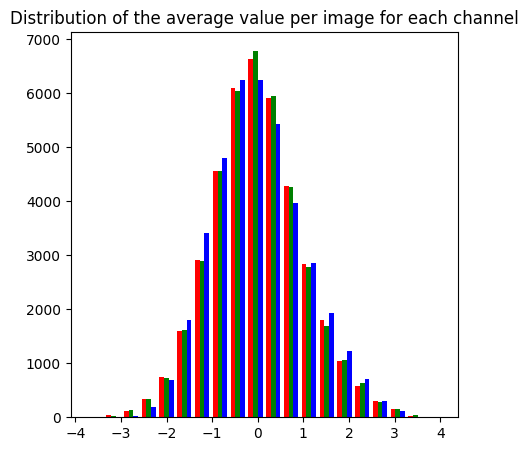

[ 5.95175719e-08 -3.37920210e-08 -9.91557841e-08] [0.99999993 0.99999993 1.        ]


In [19]:
import numpy as np
# Load the CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4917127, 0.48267886, 0.44709538], std=[0.12826901, 0.12557506, 0.15323256])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
train_subset, val_subset = torch.utils.data.random_split(trainset, [40000, 10000],
                                         generator=torch.Generator().manual_seed(1))

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=10,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=10,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def calculate_mean(dataset):
    mean_per_image_r, mean_per_image_g, mean_per_image_b = [], [], []

    for image, _ in dataset:
        mean_per_image_r.append(torch.mean(image[0,:,:]).tolist())
        mean_per_image_g.append(torch.mean(image[1,:,:]).tolist())
        mean_per_image_b.append(torch.mean(image[2,:,:]).tolist())

    return mean_per_image_r, mean_per_image_g, mean_per_image_b

mean_r, mean_g, mean_b = calculate_mean(trainloader.dataset)


plt.figure(figsize=(5,5))
plt.hist([mean_r, mean_g, mean_b], 20, color=["red", "green", "blue"])
plt.title("Distribution of the average value per image for each channel")
plt.show()

colors = np.array([mean_r, mean_g, mean_b]).T
colors_mean = np.mean(colors, axis=0)
colors_std = np.std(colors, axis=0)
print(colors_mean, colors_std)
# print(sum(mean_b)/len(mean_b), sum(mean_g)/len(mean_g), sum(mean_r)/len(mean_r))


Now it's time to setup a training loop which we use to optimize te model. We also define some additional helper functions for diagnostics.

In [20]:
def train_model(model, train_loader, num_epochs=5, lr=0.01, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    epoch_data = collections.defaultdict(list)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        if verbose:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        epoch_data['loss'].append(epoch_loss)

        plot_loss(epoch_data)
        plot_weights(model, "Current Weights")
        

def plot_weights(network, title, fignr=1):
    fig, ax = plt.subplots(1,3, figsize=(12,3), num=fignr)
    i=0
    for m in network.modules():
        if isinstance(m, nn.Conv2d):            
            ax[i].clear()
            ax[i].hist(m.weight.detach().numpy().flatten(), color="dodgerblue", bins=40)
            ax[i].set_title("Conv layer " + str(i+1) + "weights", fontsize=8)
            i+=1
    plt.suptitle(title, fontsize=10)
    plt.show()

def plot_loss(data, title='Training loss'):

    clear_output(wait=True)
    plt.figure(figsize=(12,3))
    for label,data in data.items():
        plt.plot(data, label=label, color="dodgerblue")
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(["Current loss: " + str(np.round(data[-1],3))])
    plt.show()



## Weights and Biases
The code below will initialize the layer weights and biases of the network with a constant value. (1 and 0 respectively)\
By running the codeblock you can visualize the weights and watch the training loss.\
Try to improve the training process by choosing other types of layer initialization. Check the pytorch documentation for the possibilites.

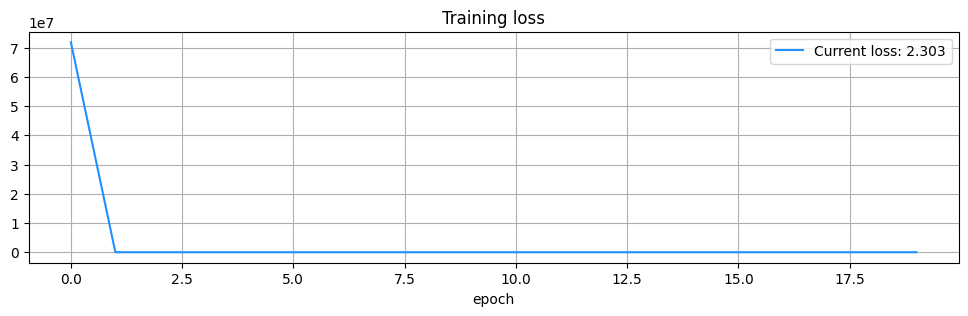

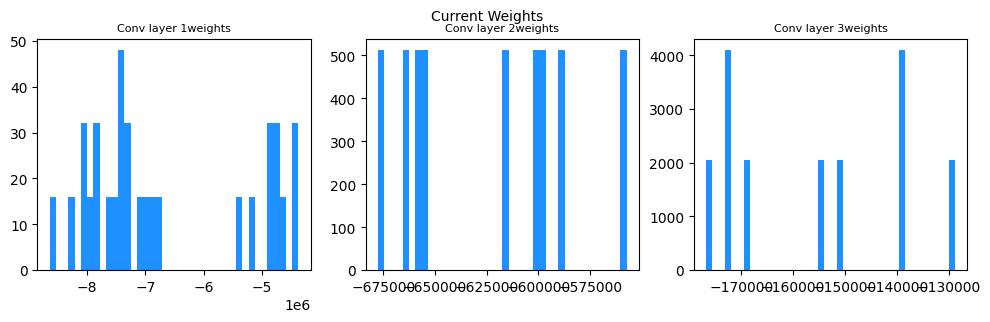

In [21]:
simple_cnn = SimpleCNN()

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.constant_(m.weight, 1) 
        if m.bias is not None:
            m.bias.data.zero_()
    if isinstance(m, nn.Linear):
        torch.nn.init.constant_(m.weight, 1) 
        if m.bias is not None:
            m.bias.data.zero_()
    # TODO: implement different kind of initalization method

# Apply the weights and biases before training
simple_cnn.apply(init_weights)

# Plot the distribution of the weights
plot_weights(simple_cnn, "Initialized Weights", fignr=0)

# Set hyperparameters
nb_epochs = 20
learning_rate = 0.001

# Start model training 
train_model(simple_cnn, trainloader, nb_epochs, learning_rate, verbose=False)

## Batch Normalization
As we have learned in the lecture, training can be optimized by reducing the covariance shift in the network. We do this by implementing batch normalization in the network. Add a batch normalization layers in the network and observe the training curve.

In [22]:
# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    # TODO: Add batchnormalization layers in the CNN model
                    
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 4 * 4, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 4 * 4)
        x = self.fc(x)
        return x

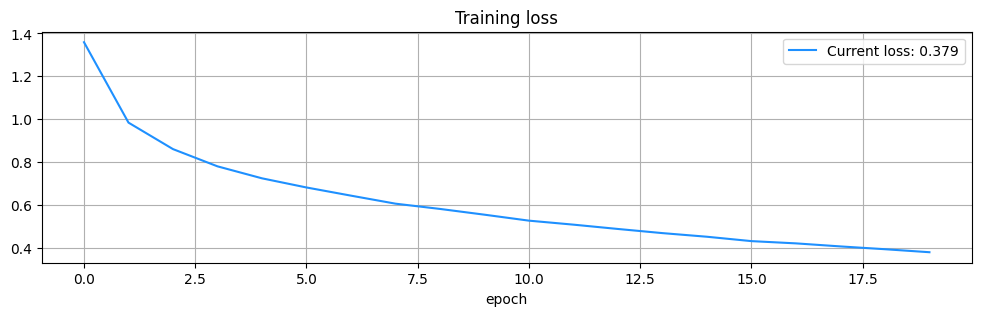

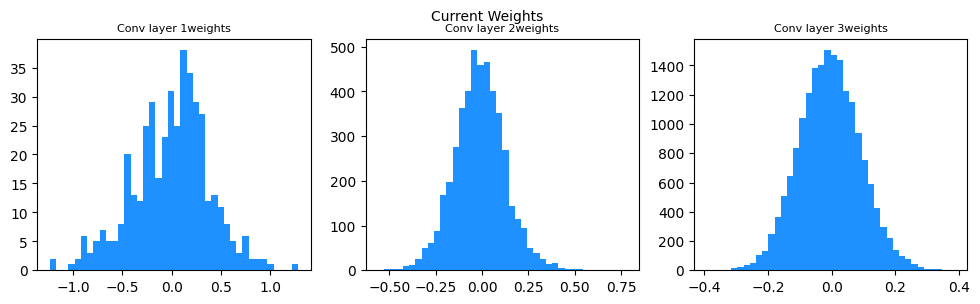

In [23]:
simple_cnn = SimpleCNN()

# Set hyperparameters
nb_epochs = 20
learning_rate = 0.001

# Start model training 
train_model(simple_cnn, trainloader, nb_epochs, learning_rate, verbose=False)

#### Questions
**Q1.** Why is normalization such an important concept with model training?

**Q2.** Can you explain the concept of Xavier normalization? How does it address the vanishing and exploding gradient problem?

**Q3.** Can you explain discuss the benefits of batch normalization?

When optimizing a big model it is always recommended to first experiment with a single image and check if the training loss goes to zero. This is a quick sanity check if the model is able to learning something. Because we already know our model is working, we skip this step for now. But keep this in mind when implementing your own custom models.

## Optimization
Next we would like to pick the best optimizer. Currently stocastic gradient descent (SGD) is used, but as already explained in the lecture, this is not the most robust solution.\ Check the documentation which optimizers are available in Pytorch and try them. Note: Diffrences between optimizers are more prevalent with worse network initializations.

In [24]:
def train_model(model, train_loader, val_loader, num_epochs=5, lr=0.01, verbose=True):
    criterion = nn.CrossEntropyLoss()
    ## To do: define your optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    epoch_data = collections.defaultdict(list)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        if verbose:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        epoch_data['loss'].append(epoch_loss)

        running_loss = 0.0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()      

        validation_loss = running_loss / len(val_loader)
        if verbose:
            print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {epoch_loss:.4f}')

        epoch_data['validation_loss'].append(validation_loss)  

        plot_loss(epoch_data)

def plot_loss(data, title='Loss'):

    clear_output(wait=True)
    plt.figure(figsize=(12,3))
    for label,data in data.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(["Train loss", "Validation Loss"])
    plt.show()        

# Assign the model        
simple_cnn = SimpleCNN()

# Set hyperparameters
nb_epochs = 40
learning_rate = 0.0001

# Start model training 
train_model(simple_cnn, trainloader, valloader, nb_epochs, learning_rate, verbose=False)

KeyboardInterrupt: 

## Regularization
As you can see in the previous section, te training severely suffers from overfitting. In order to prevent this, regularization is needed.\
Now it is time to try different forms of regularization on the network and check if performance improves.

#### Questions
**Q4.** Can you explain the Adam optimizer and its advantages over traditional gradient descent methods?

**Q5.** Try to think of other regularization methods and try to implement at least 2 more?

## Final Optimization
Now you have experienced many important aspects regarding neural network training, it's time to squeeze out every possible bit of performance. We do this by optimizing all hyperparameters. Try different settings for e.g. optimizer parameters such as learning rate, number of epochs, regularization strength. Also have a look at learning rate schedulers.\
Next week we will learn how to properly benchmark the performance of a network by discussing various evaluation metrics. But for now, check the model accuracy on the test set with the function below.

In [25]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels  # Assuming you're using GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy on the test set: {:.2f}%'.format(accuracy))

test_model(simple_cnn, testloader)

Accuracy on the test set: 46.35%


You may want to try to optimize a different network architecture. Feel free to pick your own model and apply the things you have just learned!